<a href="https://colab.research.google.com/github/DivyaNarayan0613/DivyaNarayan0613/blob/main/GENAI_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

torch – The core PyTorch library for tensor computations, similar to NumPy but optimized for GPU acceleration.

torch.nn – Provides modules and functions for building neural networks, including layers, activation functions, and loss functions.

torch.optim – Contains optimization algorithms (e.g., SGD, Adam) used for training neural networks by adjusting model weights.

torchvision.datasets – Provides access to popular datasets (like MNIST, CIFAR-10) and utilities for loading image data.

torchvision.transforms – Offers data transformation utilities (e.g., normalization, resizing, augmentation) for preprocessing images.

torch.utils.data.DataLoader – Facilitates efficient loading and batching of datasets, enabling parallel processing.

matplotlib.pyplot – Used for visualizing data, such as plotting training loss curves or displaying images from the dataset.

numpy – Provides numerical computing capabilities and array operations, often used for preprocessing and analysis.

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


torch.cuda.is_available(): Checks if a compatible NVIDIA GPU is available and if PyTorch has CUDA support enabled.
If True → Uses "cuda" (GPU) for faster computations.
If False → Falls back to "cpu" (slower but works universally).

GPU acceleration: Deep learning models train much faster on GPUs due to parallel processing.

Portability: This approach makes your code flexible—it will automatically use a GPU if available, otherwise, it runs on the CPU.

In [ ]:
# Check device (GPU recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


latent_dim = 100

    This represents the dimension of the noise vector (z), typically used in GANs.
    The generator takes this as input to produce realistic-looking images.

batch_size = 128

    Determines how many samples are processed before updating the model weights.
    A larger batch size can stabilize training but requires more memory.

lr = 0.0002 (Learning Rate)

    Controls how much the model’s weights change at each step.
    A value of 0.0002 is commonly used in GANs (e.g., DCGAN).
    Too high → Model might not converge.
    Too low → Training might be too slow.

epochs = 50

    The number of times the entire dataset is passed through the model.
    More epochs allow the model to learn better, but too many can lead to overfitting.

In [ ]:
# Define hyperparameters
latent_dim = 100    # Dimension of the noise vector
batch_size = 128    # Batch size
lr = 0.0002         # Learning rate
epochs = 50         # Number of epochs


transforms.ToTensor() → Converts the image to a PyTorch tensor (shape: [C, H, W], values in [0,1]).
transforms.Normalize([0.5], [0.5]) → Normalizes pixel values to [-1, 1].

    Original pixel values: [0, 255]
    After .ToTensor(): [0, 1]
    Normalization formula: (x - mean) / std → (x - 0.5) / 0.5 → results in values between -1 and 1
    This is often used in GANs (e.g., DCGAN) since Tanh activation performs better with normalized inputs

datasets.MNIST → Loads the MNIST dataset (handwritten digit images, 28x28, grayscale).

root="./data" → Saves the dataset in the ./data directory.

train=True → Loads the training set (if False, loads test set).

transform=transform → Applies the defined transformations (ToTensor and Normalize).

download=True → Downloads the dataset if not already available.

DataLoader → Efficiently loads data in batches for training.

batch_size=batch_size → Loads 128 samples per batch (as set earlier).

shuffle=True → Shuffles the dataset each epoch to improve training performance.

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])
mnist_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.15MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



A VAE is a type of neural network that combines ideas from:

    Autoencoders: Used for learning a compressed representation (encoding) of data.
    Probabilistic Modeling: Learns to approximate the data distribution and generate new samples.

It has two main components:

    Encoder: Encodes input into a latent space (a distribution).
    Decoder: Reconstructs the input from the latent space.

The VAE class inherits from nn.Module and has three main components:

    Encoder
    Latent Space
    Decoder



# **Encoder**

self.encoder = nn.Sequential(
    nn.Linear(28 * 28, 400),
    nn.ReLU()
)

self.fc_mu = nn.Linear(400, latent_dim)  # Mean of latent distribution

self.fc_logvar = nn.Linear(400, latent_dim)  # Log-variance of latent
distribution

The Encoder reduces the input dimension (flattened 28x28 image) to a hidden representation (h of size 400).

Two separate linear layers (fc_mu and fc_logvar) compute:

    mu: The mean of the latent distribution.
    logvar: The logarithm of the variance of the latent distribution.

This latent distribution is parameterized as a Gaussian distribution.

# **Reparameterization Trick**

def reparameterize(self, mu, logvar):

    std = torch.exp(0.5 * logvar)

    eps = torch.randn_like(std)

    return mu + eps * std

Instead of sampling directly from the latent distribution (which isn't differentiable), the reparameterization trick is used:

    Compute std (standard deviation) from logvar.
    Generate random noise eps from a standard normal distribution.
    Combine them


Decoder reconstructs the input from the latent variable z.

Loss function balances reconstruction quality and regularization of the latent space.

In [ ]:
# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, latent_dim)  # Mean of latent distribution
        self.fc_logvar = nn.Linear(400, latent_dim)  # Log-variance of latent distribution

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Tanh()  # Output normalized to [-1, 1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

# Loss function for VAE
def vae_loss(reconstructed, original, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    bce_loss = nn.functional.binary_cross_entropy_with_logits(reconstructed, original.view(-1, 28 * 28), reduction='sum')
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce_loss + kl_divergence



In [ ]:
# Initialize model, optimizer
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for imgs, _ in data_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = vae(imgs)
        loss = vae_loss(reconstructed, imgs, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_loss / len(data_loader.dataset):.4f}")


Epoch [1/50], Loss: -284.8522
Epoch [2/50], Loss: -327.8985
Epoch [3/50], Loss: -329.5570
Epoch [4/50], Loss: -330.6255
Epoch [5/50], Loss: -331.5967
Epoch [6/50], Loss: -332.6011
Epoch [7/50], Loss: -333.2634
Epoch [8/50], Loss: -333.4425
Epoch [9/50], Loss: -333.4845
Epoch [10/50], Loss: -333.5014
Epoch [11/50], Loss: -333.5097
Epoch [12/50], Loss: -333.5149
Epoch [13/50], Loss: -333.5181
Epoch [14/50], Loss: -333.5203
Epoch [15/50], Loss: -333.5220
Epoch [16/50], Loss: -333.5232
Epoch [17/50], Loss: -333.5241
Epoch [18/50], Loss: -333.5248
Epoch [19/50], Loss: -333.5253
Epoch [20/50], Loss: -333.5257
Epoch [21/50], Loss: -333.5261
Epoch [22/50], Loss: -333.5263
Epoch [23/50], Loss: -333.5265
Epoch [24/50], Loss: -333.5267
Epoch [25/50], Loss: -333.5268
Epoch [26/50], Loss: -333.5269
Epoch [27/50], Loss: -333.5269
Epoch [28/50], Loss: -333.5270
Epoch [29/50], Loss: -333.5270
Epoch [30/50], Loss: -333.5271
Epoch [31/50], Loss: -333.5271
Epoch [32/50], Loss: -333.5271
Epoch [33/50], Lo

This snippet is used for generating new MNIST-like images using a trained Variational Autoencoder (VAE).

1️⃣ Set Model to Evaluation Mode
This switches the model to evaluation mode, disabling dropout and batch normalization updates.

Ensures the model behaves consistently when generating images.

2️⃣ Generate Random Latent Vectors
torch.no_grad() → Disables gradient tracking to save memory (since we don’t need backpropagation for inference).

torch.randn(16, latent_dim).to(device)

    Generates 16 random latent vectors from a standard normal distribution (𝒩(0,1)).
    latent_dim = 100 (from earlier) defines the dimensionality of the latent space.
    .to(device) moves the tensor to the GPU (if available) for faster processing.

3️⃣ Decode Latent Vectors into Images
vae.decode(z) → Passes the latent vectors through the decoder part of the VAE to generate new images.

.view(-1, 1, 28, 28) → Reshapes the output into MNIST format (1x28x28, grayscale images).

.cpu() → Moves the tensor to CPU for visualization.    

4️⃣ Rescale Pixel Values to [0, 1]
Since the model outputs images in the [-1, 1] range (due to tanh activation and normalization), this rescales them back to [0, 1] for proper visualization.

5️⃣ Plot the Generated Images
Creates a 4×4 grid (16 images total) for visualization.

axs[i, j].imshow(..., cmap="gray") → Displays each generated image in grayscale.
.squeeze() → Removes extra dimensions ([1, 28, 28] → [28, 28]).

.axis("off") → Hides axis ticks for a clean look.



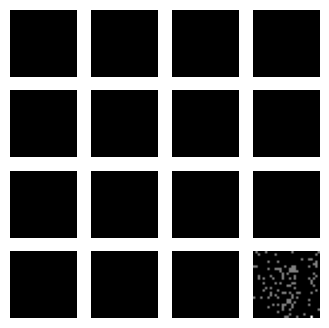

Image generation complete!


In [ ]:
# Generate new images
vae.eval()
with torch.no_grad():
    # Sample random latent vectors
    z = torch.randn(16, latent_dim).to(device)
    generated = vae.decode(z).view(-1, 1, 28, 28).cpu()
    generated = (generated + 1) / 2  # Rescale to [0, 1]

    # Plot generated images
    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(generated[i * 4 + j].squeeze(), cmap="gray")
            axs[i, j].axis("off")
    plt.show()

print("Image generation complete!")

